# Projet de machine learning en utilsant le processus CRISP-DM
Sources utilisées dans le projet :
- https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb
- Smartphone and Smartwatch-Based Biometrics Using Activities of Daily Living. IEEE Access, 7:133190-133202, Sept. 2019.

## Compréhension du problème

Il s'agira de concevoir, développer et évaluer un système d’apprentissage machine dans un projet scolaire. Le projet à donc pour vocation d'appliquer les méthodes d'apprentissage vues en cours à travers le processus CRISP-DM. Ce projet est réalisé à deux personnes. Dans cette partie on s'interessera a classifier des activités à partir d'un smartphone et d'une smartwatch sur un individu à la fois.  
Python sera ici utilisé avec l'outil JupyterLab pour la rédaction du rapport. Les modules propres à Python tels que Scikit-Learn et Pandas seront ici à l'emploie.

## Compréhension des données
### Mise en place

In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rc('axes', labelsize=14)
#mpl.rc('xtick', labelsize=12)
#mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Récupération des données

In [2]:
import zipfile
import urllib

DOWNLOAD_ROOT = "https://archive.ics.uci.edu/ml/machine-learning-databases/00507/"
WISDM_PATH = os.path.join("datasets", "wisdm")
WISDM_URL = DOWNLOAD_ROOT + "wisdm-dataset.zip"

def fetch_wisdm_data(wisdm_url=WISDM_URL, wisdm_path=WISDM_PATH):
    if not os.path.isdir(wisdm_path):
        os.makedirs(wisdm_path)
    zip_path = os.path.join(wisdm_path, "wisdm-dataset.zip")
    if not os.path.isfile(zip_path):
        urllib.request.urlretrieve(wisdm_url, zip_path)
    uncompressed_path = os.path.join(wisdm_path, "wisdm-dataset")
    if not os.path.isdir(uncompressed_path):
        with zipfile.ZipFile(zip_path,"r") as zip_ref:
            zip_ref.extractall(wisdm_path)

In [3]:
fetch_wisdm_data()

In [4]:
def load_raw_wisdm_data(subjectId, device, sensor, wisdm_path=WISDM_PATH):
    """
        Charge les données brutes.
        device : 'phone' ou 'watch'
        sensor : 'accel' ou 'gyro'
    """
    subjectIdStr = str(subjectId)
    rawPath = os.path.join(WISDM_PATH,'wisdm-dataset','raw',device,sensor,'data_'+subjectIdStr+'_'+sensor+'_'+device+'.txt')
    f = open(rawPath, 'r')
    lines = f.readlines()
    data=[[],[],[]]
    timestamp=[]
    series={}
    activities=[]
    for l in lines:
        spt=l.split(',')
        activities.append(spt[1])
        data[0].append(float(spt[3]))
        data[1].append(float(spt[4]))
        data2=spt[5].split(';')[0]
        data[2].append(float(data2))
        timestamp.append(int(spt[2]))
    f.close()
    #d={'activity': activities, 'x': data[0], 'y': data[1], 'z': data[2]}
    d={'time': timestamp, 'activity': activities, 'x': data[0], 'y': data[1], 'z': data[2]}
    df=pd.DataFrame(data=d, index=pd.to_datetime(timestamp))
    #df=pd.DataFrame(data=d)
    
    activities = df['activity'].unique()
    for activity in activities:
        serie = df.loc[df['activity']==activity]
        timestamp=serie['time'].to_numpy()
        timestamp = [(x-timestamp[0])*10**-9 for x in timestamp]
        df.loc[df['activity']==activity, 'time']=timestamp
    return df

In [5]:
# library for reading arff file
# You can install it via 'pip install liac-arff'
# https://pypi.org/project/liac-arff/ for more informations
import arff
import pandas as pd

def load_wisdm_data(subjectId, device, sensor, wisdm_path=WISDM_PATH):
    """
        Charge les données pré-traitées.
        device : 'phone' ou 'watch'
        sensor : 'accel' ou 'gyro'
    """
    subjectIdStr = str(subjectId)
    arffPath = os.path.join(WISDM_PATH,'wisdm-dataset','arff_files',device,sensor,'data_'+subjectIdStr+'_'+sensor+'_'+device+'.arff')
    f=open(arffPath, 'r')
    data = arff.load(f)
    attributesName = [data['attributes'][i][0] for i in range (len(data['attributes']))]
    dataFrame = pd.DataFrame(data = data['data'], columns=attributesName)
    f.close()
    return dataFrame

### Description des données

Les données sont décrites dans le fichier WISDM-dataset-description.pdf du jeu de données précédemment téléchargé.
Ce jeu de données est composé de données provenant de 51 personnes à qui on a demandé de réaliser 18 tâches de 3 minutes. Chacun des sujets a une smartwatch attachée au poignet de leurs mains dominantes et un smartphone dans leurs poches. Les données collectées proviennent des girocscopes et des accéléromètres de la montre et du téléphone.

Un pré-traitement des données a déja été fait dans le jeu de données. Il en résulte un des données etiquetées sur les exemples au lieu de données étiquetées sur une série temporelle. Le traitement pour faire cela consiste à utiliser une fonction porte de 10s sur chaque série temporelle de données.

Les chercheurs ont rencontrés des problèmes pour la collecte des données du gyroscope du téléphone. Ces données ci ne sont donc pas fiables et seront manipulées seulement pour illustrer le problème.

### Les données brutes

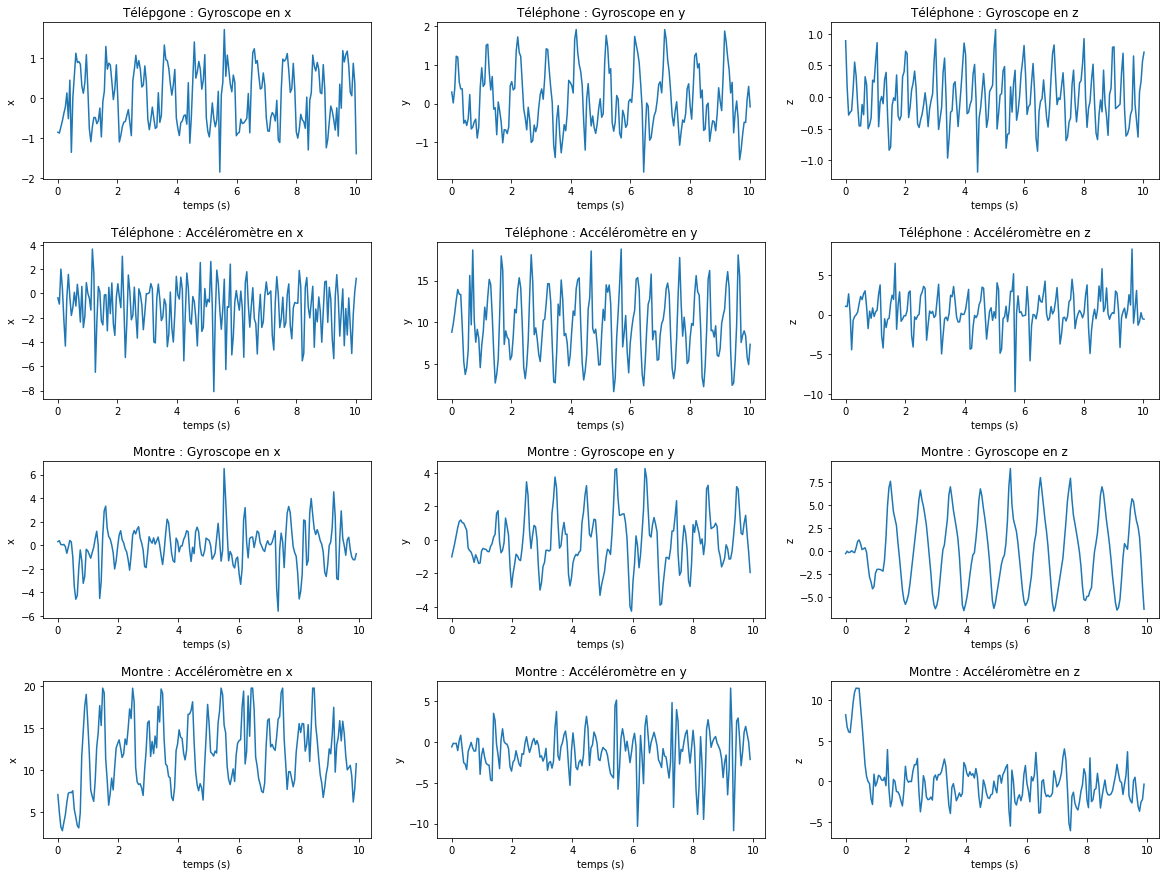

In [6]:
series_phone_gyro=load_raw_wisdm_data(1600, 'phone', 'gyro')
series_phone_accel=load_raw_wisdm_data(1600, 'phone', 'accel')
series_watch_accel=load_raw_wisdm_data(1600, 'watch', 'accel')
series_watch_gyro=load_raw_wisdm_data(1600, 'watch', 'gyro')

serie_A_phone_gyro = series_phone_gyro.loc[series_phone_gyro['activity']=='A'][0:200]
serie_A_phone_accel = series_phone_accel.loc[series_phone_accel['activity']=='A'][0:200]
serie_A_watch_accel = series_watch_accel.loc[series_watch_accel['activity']=='A'][0:200]
serie_A_watch_gyro = series_watch_gyro.loc[series_watch_gyro['activity']=='A'][0:200]

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20,15))
plt.subplots_adjust(hspace = 0.4)

#Ligne 1
axs[0, 0].set_title('Télépgone : Gyroscope en x')
axs[0, 0].set_xlabel('temps (s)')
axs[0, 0].set_ylabel('x')
axs[0, 0].plot(serie_A_phone_gyro['time'],serie_A_phone_gyro['x'])

plt.subplot(432)
plt.title('Téléphone : Gyroscope en y')
plt.xlabel('temps (s)')
plt.ylabel('y')
plt.plot(serie_A_phone_gyro['time'],serie_A_phone_gyro['y'])

plt.subplot(433)
plt.title('Téléphone : Gyroscope en z')
plt.xlabel('temps (s)')
plt.ylabel('z')
plt.plot(serie_A_phone_gyro['time'],serie_A_phone_gyro['z'])

#Ligne 2
plt.subplot(434)
plt.title('Téléphone : Accéléromètre en x')
plt.xlabel('temps (s)')
plt.ylabel('x')
plt.plot(serie_A_phone_accel['time'],serie_A_phone_accel['x'])

plt.subplot(435)
plt.title('Téléphone : Accéléromètre en y')
plt.xlabel('temps (s)')
plt.ylabel('y')
plt.plot(serie_A_phone_accel['time'],serie_A_phone_accel['y'])

plt.subplot(436)
plt.title('Téléphone : Accéléromètre en z')
plt.xlabel('temps (s)')
plt.ylabel('z')
plt.plot(serie_A_phone_accel['time'],serie_A_phone_accel['z'])

#Ligne 3
plt.subplot(437)
plt.title('Montre : Gyroscope en x')
plt.xlabel('temps (s)')
plt.ylabel('x')
plt.plot(serie_A_watch_gyro['time'],serie_A_watch_gyro['x'])

plt.subplot(438)
plt.title('Montre : Gyroscope en y')
plt.xlabel('temps (s)')
plt.ylabel('y')
plt.plot(serie_A_watch_gyro['time'],serie_A_watch_gyro['y'])

plt.subplot(439)
plt.title('Montre : Gyroscope en z')
plt.xlabel('temps (s)')
plt.ylabel('z')
plt.plot(serie_A_watch_gyro['time'],serie_A_watch_gyro['z'])

#Ligne 1
axs[3, 0].set_title('Montre : Accéléromètre en x')
axs[3, 0].set_xlabel('temps (s)')
axs[3, 0].set_ylabel('x')
axs[3, 0].plot(serie_A_watch_accel['time'],serie_A_watch_accel['x'])

axs[3, 1].set_title('Montre : Accéléromètre en y')
axs[3, 1].set_xlabel('temps (s)')
axs[3, 1].set_ylabel('y')
axs[3, 1].plot(serie_A_watch_accel['time'],serie_A_watch_accel['y'])

axs[3, 2].set_title('Montre : Accéléromètre en z')
axs[3, 2].set_xlabel('temps (s)')
axs[3, 2].set_ylabel('z')
axs[3, 2].plot(serie_A_watch_accel['time'],serie_A_watch_accel['z'])

plt.show()

#### Exemple de spectre

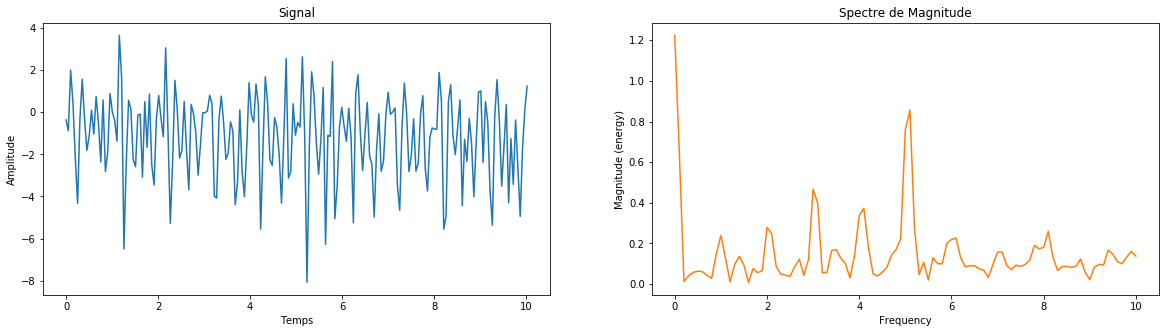

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

axes[0].set_title("Signal")
axes[0].plot(serie_A_phone_accel['time'], serie_A_phone_accel['x'], color='C0')
axes[0].set_xlabel("Temps")
axes[0].set_ylabel("Amplitude")

axes[1].set_title("Spectre de Magnitude")
axes[1].magnitude_spectrum(serie_A_phone_accel['x'],Fs=20, color='C1')

plt.show()

Ce spectre de magnitude à était réalisé à titre d'exemple. Il est possible d'extraire des caractéristiques importantes de ce spectre comme les piques de fréquence par exemple.

### Corrélation entre les signaux

On s'interesse ici à la corrélation entre les différents signaux et pour chaque activités.  
Les corrélations suivantes ont étaient calculées pour le sujet 1600 uniquement et sur le capteur en x seulement par soucis de lisibilité.

In [8]:
ACTIVITIES_CODE=[chr(i) for i in range(ord('A'),ord('S')+1)]
#Il n'y a pas d'activité N
ACTIVITIES_CODE.remove('N')

for code in ACTIVITIES_CODE:

    serie_code_phone_gyro = series_phone_gyro.loc[series_phone_gyro['activity']==code]
    serie_code_phone_accel = series_phone_accel.loc[series_phone_accel['activity']==code]
    serie_code_watch_accel = series_watch_accel.loc[series_watch_accel['activity']==code]
    serie_code_watch_gyro = series_watch_gyro.loc[series_watch_gyro['activity']==code]

    length1=len(serie_code_phone_gyro)
    length2=len(serie_code_phone_accel)
    length3=len(serie_code_watch_accel)
    length4=len(serie_code_watch_gyro)
    
    #Les séries ayant des longueurs différentes (Chaque activité n'a pas la même durée), on prend la longueur minimum
    length=min(length1,length2,length3,length4)

    x=serie_code_phone_accel['x'].head(length)
    y=serie_code_phone_gyro['x'].head(length)
    z=serie_code_watch_accel['x'].head(length)
    w=serie_code_watch_gyro['x'].head(length)
    
    df=pd.DataFrame({'phone_accel':x.values, 'phone_gyro':y.values, 'watch_accel':z.values, 'watch_gyro':w.values})
    df=df.corr()
    print("Actvité : ",code," : ","\n",df,'\n')

Actvité :  A  :  
              phone_accel  phone_gyro  watch_accel  watch_gyro
phone_accel     1.000000   -0.120744    -0.016635   -0.012606
phone_gyro     -0.120744    1.000000     0.047844    0.044062
watch_accel    -0.016635    0.047844     1.000000    0.059629
watch_gyro     -0.012606    0.044062     0.059629    1.000000 

Actvité :  B  :  
              phone_accel  phone_gyro  watch_accel  watch_gyro
phone_accel     1.000000   -0.131543     0.000069   -0.008299
phone_gyro     -0.131543    1.000000    -0.012437   -0.004088
watch_accel     0.000069   -0.012437     1.000000   -0.262886
watch_gyro     -0.008299   -0.004088    -0.262886    1.000000 

Actvité :  C  :  
              phone_accel  phone_gyro  watch_accel  watch_gyro
phone_accel     1.000000   -0.160703    -0.033941    0.051982
phone_gyro     -0.160703    1.000000     0.047608   -0.077946
watch_accel    -0.033941    0.047608     1.000000   -0.113491
watch_gyro      0.051982   -0.077946    -0.113491    1.000000 

Actvité

Aucune corrélation ne semble se dégager de ces matrices de corrélation. On ne peut donc rien déduire sur la similitude des signaux et on gardera tout les signaux pour la modélisation.

### Les donées pré-traitées

#### Données de l'accéléromètre du téléphone

In [9]:
subject1600_phone_accel = load_wisdm_data(1600, 'phone', 'accel')
subject1600_phone_accel.head()

,ACTIVITY,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT,class
0,A,0.235,0.470,0.275,0.020,0.000,0.0,0.0,0.0,0.0,...,0.486106,0.479859,-0.550668,0.049864,0.121354,-0.251024,0.164468,-0.110722,10.05180,1600
1,A,0.275,0.440,0.270,0.015,0.000,0.0,0.0,0.0,0.0,...,0.479571,0.473409,-0.633171,0.072129,0.161492,-0.386416,0.215680,-0.034375,10.11710,1600
2,A,0.320,0.430,0.245,0.000,0.005,0.0,0.0,0.0,0.0,...,0.483005,0.476798,-0.659493,0.087043,0.162157,-0.325151,0.272380,-0.077274,9.98384,1600
3,A,0.315,0.495,0.185,0.005,0.000,0.0,0.0,0.0,0.0,...,0.480711,0.474534,-0.712081,0.003810,0.210015,-0.364285,0.203131,0.015328,10.10600,1600
4,A,0.215,0.455,0.325,0.005,0.000,0.0,0.0,0.0,0.0,...,0.468836,0.462811,-0.534933,0.047553,0.275833,-0.216423,0.238500,-0.009870,10.05210,1600


In [10]:
subject1600_phone_accel.describe()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,ZMFCC10,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT
count,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.0,321.0,...,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000
mean,0.128816,0.264517,0.319969,0.235031,0.051277,0.000312,0.000047,0.000031,0.0,0.0,...,0.339085,0.335138,0.330831,0.221916,0.558735,0.595346,-0.100686,0.105777,-0.421535,9.697830
std,0.214657,0.335906,0.415449,0.402267,0.206116,0.001499,0.000482,0.000394,0.0,0.0,...,0.143267,0.141599,0.139780,0.862872,0.579945,0.550815,0.365069,0.421341,0.391955,0.460055
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,-0.060974,-0.060264,-0.059490,-0.999917,-0.997769,-0.952187,-0.999753,-0.986312,-0.999803,9.171570
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.327565,0.323752,0.319591,-0.724125,0.098196,0.151871,-0.322235,-0.179483,-0.738426,9.327910
50%,0.000000,0.000000,0.120000,0.005000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.367562,0.363283,0.358614,0.986246,0.965633,0.994368,-0.076160,0.100942,-0.557509,9.637580
75%,0.240000,0.520000,0.905000,0.125000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.409566,0.404798,0.399596,0.999207,0.999106,0.999577,0.127908,0.442266,-0.053193,9.985840
max,1.000000,1.000000,1.000000,1.000000,0.995000,0.010000,0.005000,0.005000,0.0,0.0,...,0.664408,0.656673,0.648235,0.999982,0.999951,0.999939,0.975860,0.999756,0.565919,11.428800


On voit déja que les données ne sont pas normalisées car le min et le max ont des valeurs différentes selon les données.

## Séléction des données

### Histogramme des données du sujet 1600

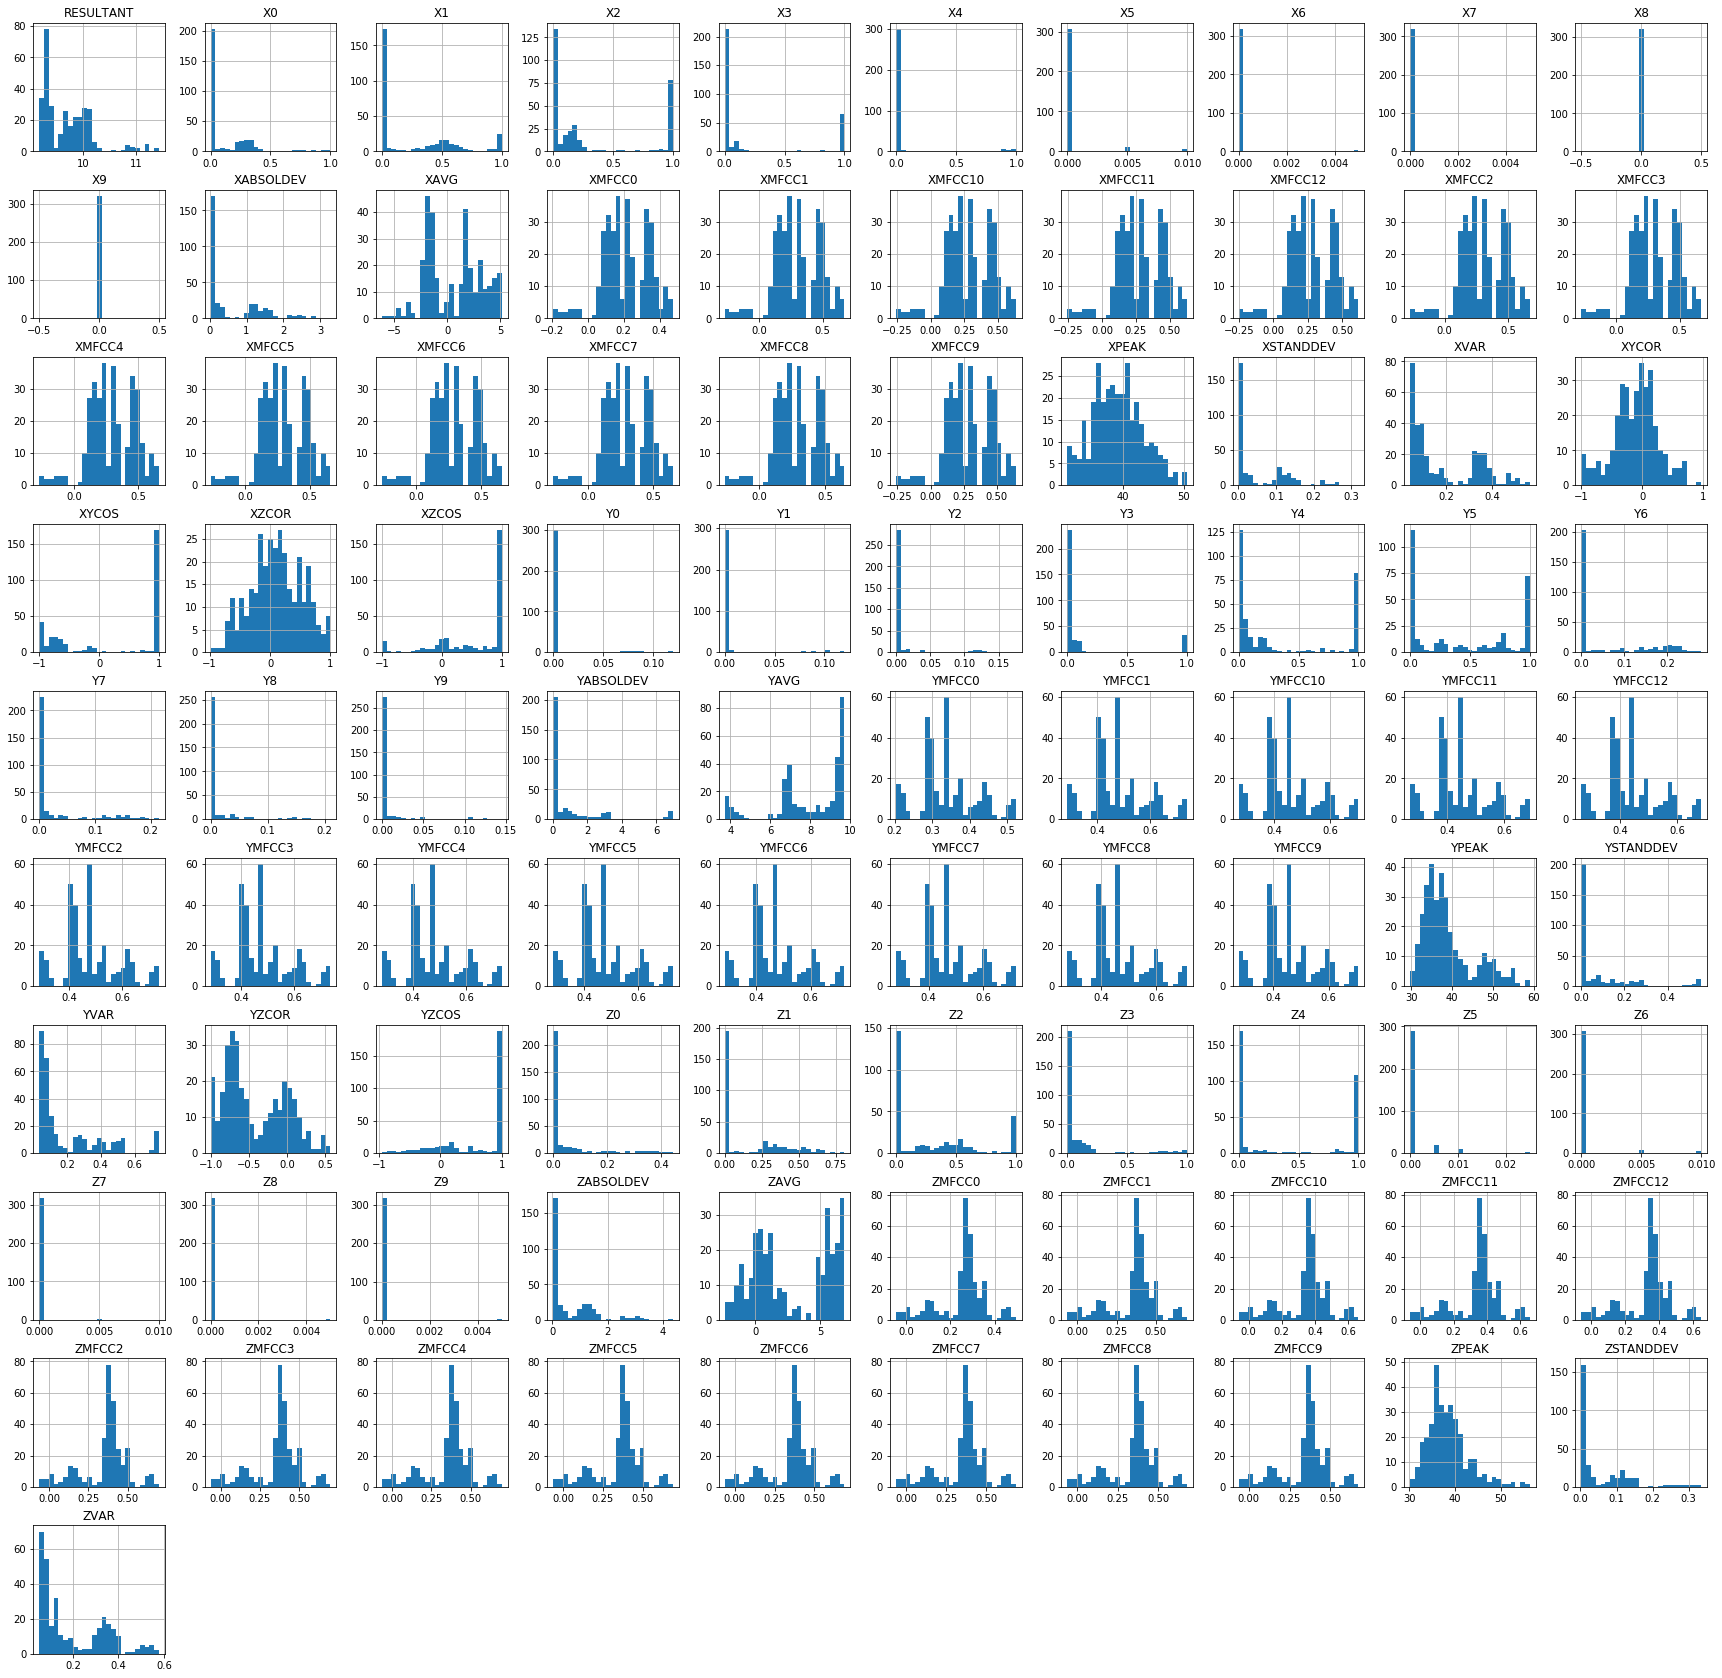

In [11]:
subject1600_phone_accel.hist(bins = 25, figsize=(30,30))
#save_fig("attribute_histogram_plots")
plt.show()

On remarque dans l'histogramme que certains attributs comme X0 et X3 n'ont que très peu de dispersion. D'autres n'ont aucune dispersion comme X7 et X8 qui sont nuls tout le temps. On va essayer de voir si ces attributs sont utiles ou si on peut les enlever pour la suite.  
Les histogrammes XMFCC{0-12}, YMFCC{0-12} et ZMFCC{0-12} semblent similaires, on peut regarder le coefficient de corrélation entre ces derniers pour connaitre le niveau de similitude de ces attributs.

### Corrélation des attributs de puissance spéctrales (XMFCC, YMFCC, ZMFCC) du sujet 1600

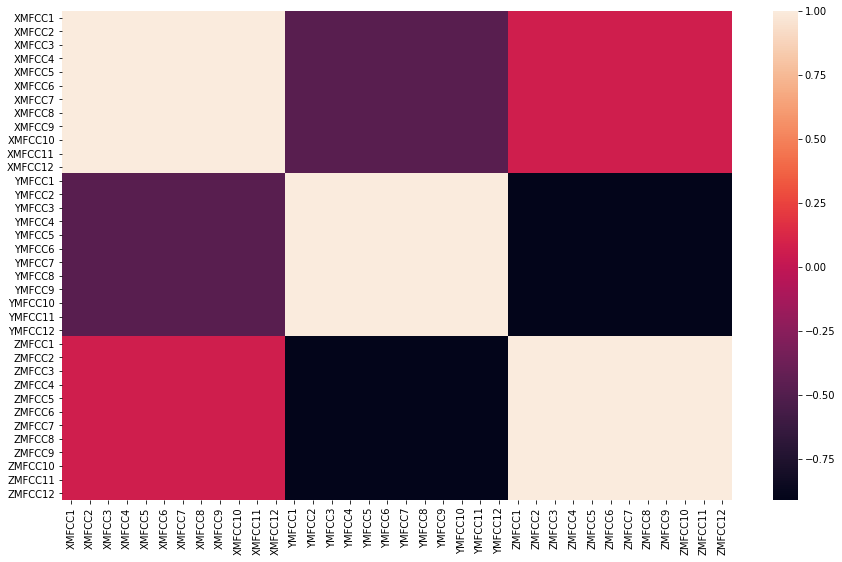

In [12]:
corr_matrix = subject1600_phone_accel.corr()
corr_matrix = corr_matrix**2

elements1=['XMFCC','YMFCC','ZMFCC']
attributes=[e+str(i) for e in elements1 for i in range (1,13)]

power_spectrum_corr=corr_matrix[attributes].loc[attributes]

fig, ax = plt.subplots(figsize=(15,9))
heat_map = sns.heatmap(power_spectrum_corr.corr())
plt.show()

Les attributs XMFCC{0-12} sont effectivement corrélés avec un coefficient égal à 1. Il ne semble pas important de garder tout ces attributs pour le sujet 1600. Il en est de même pour les attributs YMFCC{0-12} et ZMFCC{0-12}.  
On va alors regarder si ces attributs sont inutiles pour tous les sujets ou s'ils le sont seulement pour le sujet 1600 afin de savoir si l'on peu les retirer.

### Histogramme des données de tous les sujets

In [13]:
import random
import pandas as pd

SUBJECT_NUMBER = 51
FIRST_SUBJECT_ID=1600
SUBJECTSID = [i+FIRST_SUBJECT_ID for i in range(SUBJECT_NUMBER)]
#Le sujet 1614 n'est pas dans la liste ...
SUBJECTSID.remove(1614)

def load_multiple_wisdm_data(subjectToExtractNumber, device, sensor):
    #for reproductibility
    random.seed(1)
    subjectsToExtract = random.sample(SUBJECTSID,subjectToExtractNumber)
    
    subject = load_wisdm_data(1600, device, sensor) 
    subjectsDf = pd.DataFrame(columns=subject.columns)
    for i in range(subjectToExtractNumber):
        subjectDf = load_wisdm_data(subjectsToExtract[i], device, sensor)
        subjectsDf = subjectsDf.append(subjectDf)
    return subjectsDf

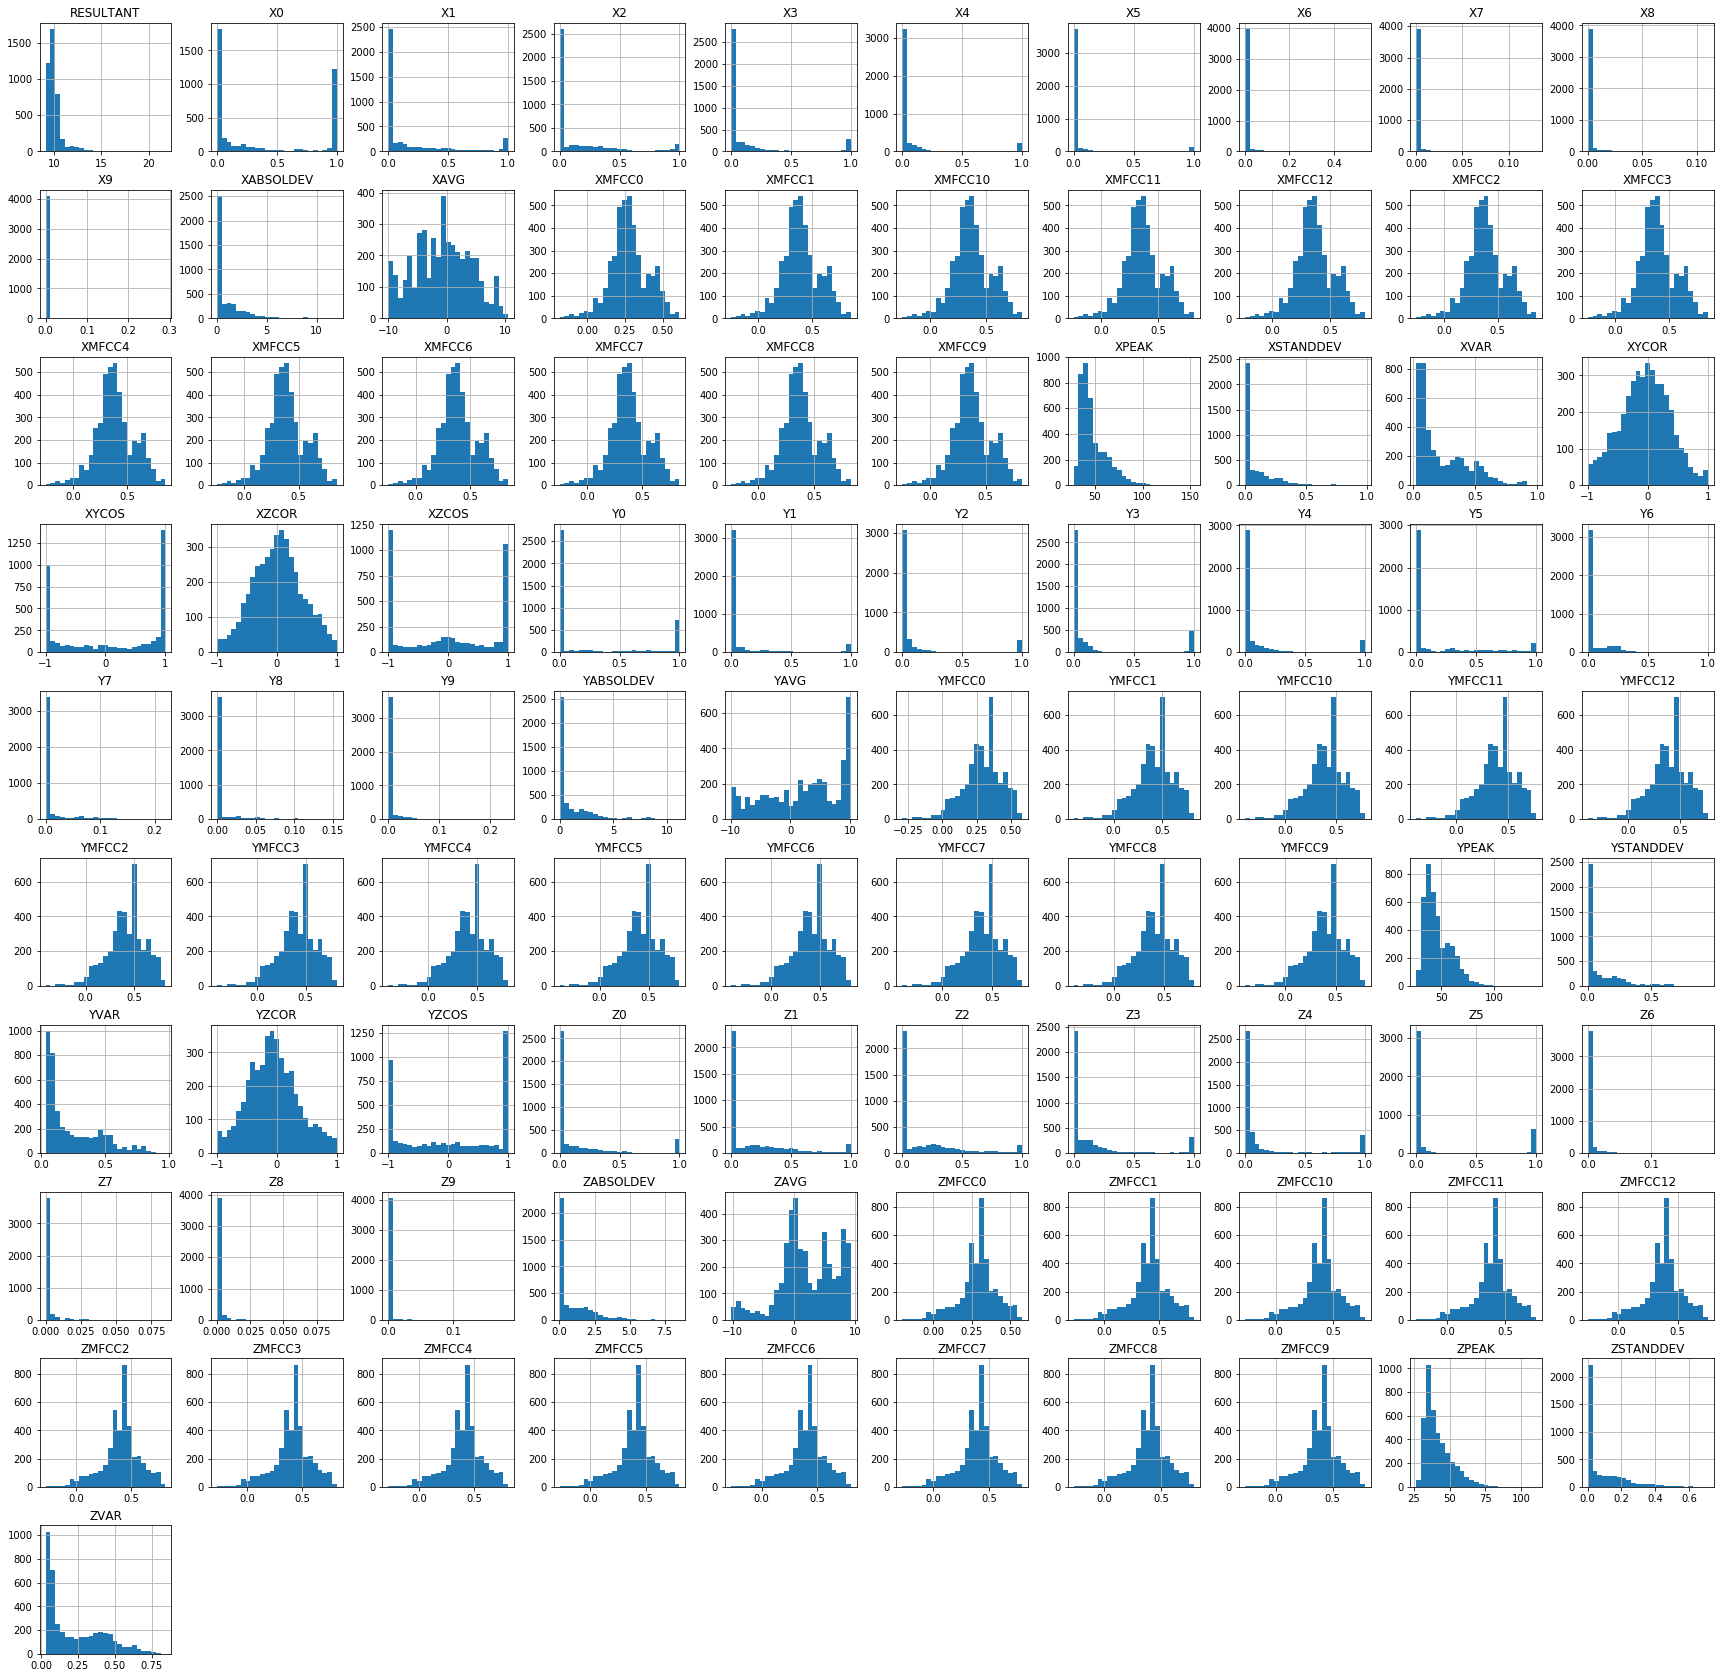

In [14]:
subjects_phone_accel = load_multiple_wisdm_data(10, 'phone', 'accel')
subjects_phone_accel.hist(bins = 25, figsize=(30,30))
#save_fig("attribute_histogram_plots")
plt.show()

La tendance se confirme, les attributs de la MFCC (Mel-frequency cepstrum) que sont les XMFCC{0-12} les YMFCC{0-12} et les ZMFCC{0-12} possède chacun les mêmes histogrammes. Ils ne semblent donc pas pertinent de garder tout ces attributs pour l'apprentissage. Nous pourons par la suite en sélectionner seulement un de chaque (XMFCC0, YMFCC0 et ZMFCC0 par exemple).
Les X{6-9}, Y{6-9} et Z{6-9} n'ont que très peu, voir pas, de dispersions et il pourrait être interressant de voir s'ils sont vraiment nécessaires à la réalisation d'un classifieur performant.

### Histogramme des données réduit (sans las atributs de la MFCC)

In [15]:
elements1=['XMFCC','YMFCC','ZMFCC']
elements2=['X','Y','Z']

attributes2=[e+str(i) for e in elements1 for i in range (1,13)] + [e+str(i) for e in elements2 for i in range (0,10)]

reducedSubjects_phone_accel = subjects_phone_accel.drop(attributes2, axis=1)

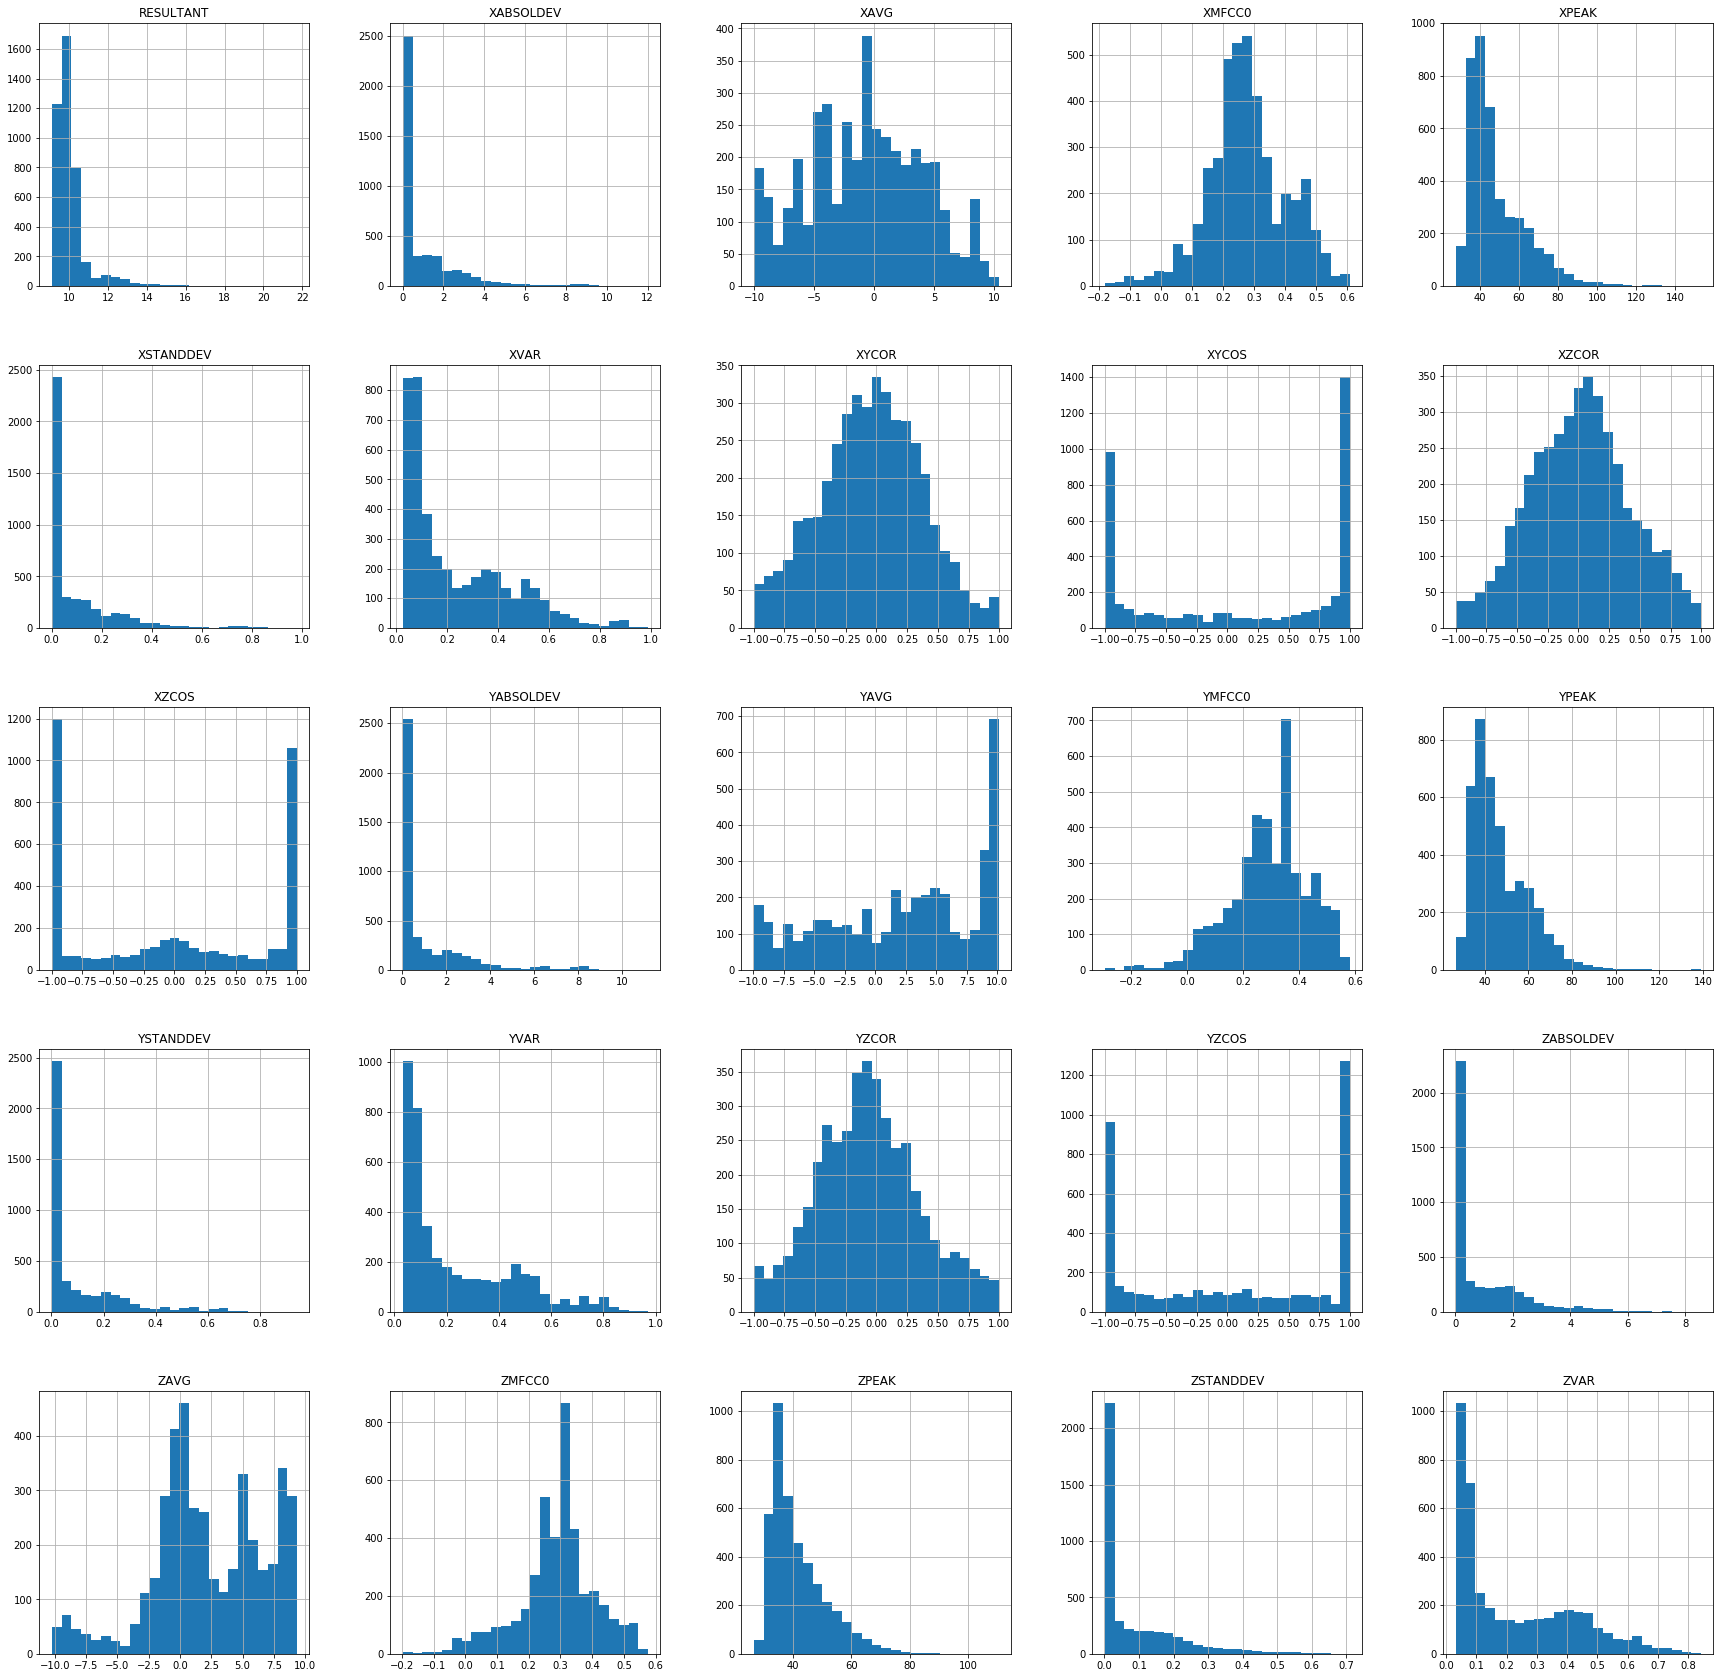

In [16]:
reducedSubjects_phone_accel.hist(bins = 25, figsize=(30,30))
#save_fig("attribute_histogram_plots")
plt.show()

### Matrice de corrélation inter-attributs

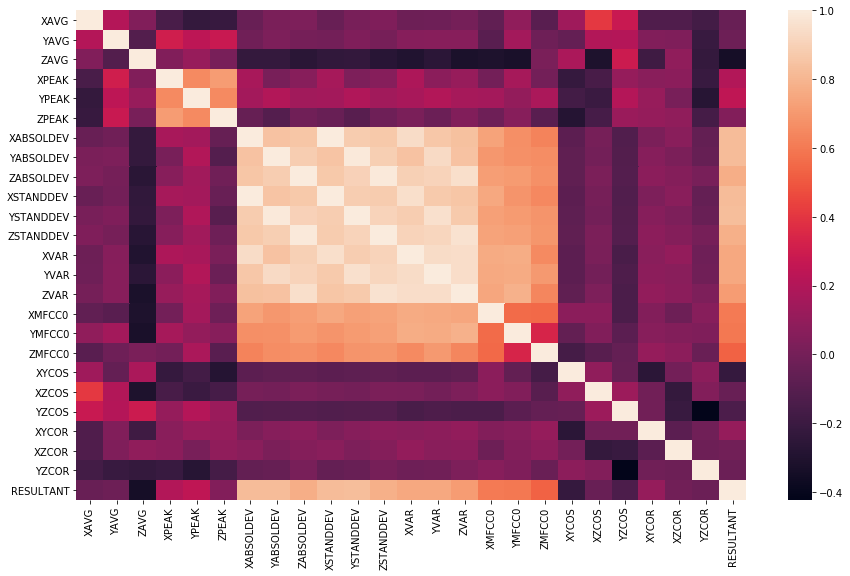

In [17]:
fig, ax = plt.subplots(figsize=(15,9))
sns.color_palette("hls", 8)
heat_map = sns.heatmap(reducedSubjects_phone_accel.corr())
plt.show()

Cette carte de chaleur représente la corrélation entre les différents attributs. On voit rapidement que les attributs XABSOLDEV à ZVAR sont tous très corrélés entre eux. Il pourrait être interressant de ne garder qu'un seul de ces attributs (XABSOLDEV par exemple) et regarder l'impact sur les performances du classifieur.

In [18]:
attributes3=['YABSOLDEV','ZABSOLDEV','XSTANDDEV','YSTANDDEV','ZSTANDDEV','XVAR','YVAR','ZVAR']

### Corrélation entre les données des différents capteurs et appareils

In [19]:
subject1600_phone_accel = load_wisdm_data(1600, 'phone', 'accel')
subject1600_phone_gyro = load_wisdm_data(1600, 'phone', 'gyro')
subject1600_watch_accel = load_wisdm_data(1600, 'watch', 'accel')
subject1600_watch_gyro = load_wisdm_data(1600, 'watch', 'gyro')
corrThreshold=0.7

#### Corrélation entre les appareils

In [20]:
corr1=subject1600_watch_gyro.corrwith(subject1600_watch_accel, axis = 0).sort_values(ascending=False)
corr1=corr1**2
corr1[corr1>corrThreshold]

RESULTANT    0.882482
YMFCC4       0.816684
YMFCC12      0.816684
YMFCC10      0.816684
YMFCC2       0.816684
YMFCC0       0.816684
YMFCC9       0.816684
YMFCC3       0.816684
YMFCC5       0.816684
YMFCC7       0.816684
YMFCC6       0.816684
YMFCC1       0.816684
YMFCC11      0.816684
YMFCC8       0.816684
XVAR         0.768006
XSTANDDEV    0.711269
XABSOLDEV    0.707384
dtype: float64

In [21]:
corr2=subject1600_phone_gyro.corrwith(subject1600_phone_accel, axis = 0).sort_values(ascending=False)
corr2=corr2**2
corr2[corr2>corrThreshold]

ZVAR         0.900846
XVAR         0.895959
ZSTANDDEV    0.894419
XSTANDDEV    0.865132
ZABSOLDEV    0.842352
XABSOLDEV    0.800665
RESULTANT    0.785973
YVAR         0.765130
dtype: float64

#### Corrélation entre les capteurs

In [22]:
corr3=subject1600_watch_accel.corrwith(subject1600_phone_accel, axis = 0).sort_values(ascending=False)
corr3=corr3**2
corr3[corr3>corrThreshold]

Series([], dtype: float64)

In [23]:
corr4=subject1600_watch_gyro.corrwith(subject1600_phone_gyro, axis = 0).sort_values(ascending=False)
corr4=corr4**2
corr4[corr4>corrThreshold]

Series([], dtype: float64)

## Modélisation

### SVM holdout

In [24]:
from sklearn.model_selection import train_test_split
from sklearn import svm

y=subject1600_phone_accel['ACTIVITY']
X=subject1600_phone_accel.drop('ACTIVITY', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8449612403100775

### SVM cross-validation

In [25]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score

y=subject1600_phone_accel['ACTIVITY']
X=subject1600_phone_accel.drop('ACTIVITY', axis=1)

clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.17)


### SVM GridSearch avec cross-validation

In [26]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
#ignore the sklearn  warnings : Precision is ill-defined and being set to 0.0 in labels with no predicted samples

y=subject1600_phone_accel['ACTIVITY']
X=subject1600_phone_accel.drop('ACTIVITY', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, cv=5, scoring='%s_macro' % score, iid=False
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
warnings.filterwarnings('always')

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:

0.222 (+/-0.070) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.025 (+/-0.020) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.635 (+/-0.157) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.250 (+/-0.070) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.814 (+/-0.150) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.640 (+/-0.144) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.858 (+/-0.101) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.843 (+/-0.108) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.843 (+/-0.092) for {'C': 1, 'kernel': 'linear'}
0.860 (+/-0.114) for {'C': 10, 'kernel': 'linear'}
0.856 (+/-0.084) for {'C': 100, 'kernel': 'linear'}
0.856 (+/-0.084) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full ev